In [1]:
import pandas as pd
import numpy as np
!pip install pandas-ta
import pandas_ta as ta
from tensorflow.keras.layers import LSTM,Dense,Dropout,BatchNormalization,Bidirectional,Input,Conv1D,Flatten,Conv1D
from tensorflow.keras.activations import relu,sigmoid,tanh,linear
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
# from keras_tuner.tuners import BayesianOptimization
# from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
# from keras_tuner.tuners import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping
import  matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split



In [2]:
df = pd.read_csv('CBOE_DLY_SPX, 60 (1).csv')

In [3]:
df = df.drop(columns='Volume',axis=1)

In [4]:
# import pandas as pd
df['time'] = pd.to_datetime(df['time'])
# df['week'] = df['time'].dt.day_name()
df.set_index('time',inplace=True)
# print(df['week'].unique)

C:\Users\Mahdimtd\AppData\Local\Temp\ipykernel_10420\1742318408.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['time'] = pd.to_datetime(df['time'])


In [5]:
df['next_hour_close'] = df['close'].shift(-1)
df['ema5'] = ta.ema(df['close'] , length=5)
df['ema10'] = ta.ema(df['close'] , length=10)
df['ema20'] = ta.ema(df['close'] , length=20)
df['ema50'] = ta.ema(df['close'] , length=50)
df['ema200'] = ta.ema(df['close'] , length=200)
df['atr'] = df['high'] - df['low']
df['atr'] = df['atr'].rolling(14).mean()
df['rsi'] = ta.rsi(df['close'] , length=14)
macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
df = pd.concat([df,macd],axis=1)
df['pivot'] = (df['high'] + df['low'] + df['close']) / 3
df['support_1'] = (2 * df['pivot']) - df['high']
df['support_2'] = df['pivot'] - (df['high'] - df['low'])
df['resistance_1'] = (2 * df['pivot']) - df['low']
df['resistance_2'] = df['pivot'] + (df['high'] - df['low'])
bollinger = ta.bbands(df['close'],length=20,std=2)
df = pd.concat([df,bollinger],axis=1)
stochastic = ta.stoch(df['high'], df['low'], df['close'], k=14, d=3, smooth_k=3)
df = pd.concat([df, stochastic], axis=1)
adx = ta.adx(df['high'], df['low'], df['close'], length=14)
df = pd.concat([df, adx], axis=1)
def fibonacci_retracement(df):
    high = df['high'].max()
    low = df['low'].min()

    diff = high - low

    df['fibonaccilevel2'] = high - 0.382 * diff
    df['fibonaccilevel3'] = high - 0.5 * diff
    df['fibonaccilevel4'] = high - 0.618 * diff
    df['fibonaccilevel5'] = high - 0.764 * diff

    return df

# fibonacci_retracement(df)

def stochastic_oscillator(df, period=14, ma_period=3):
    df['L14'] = df['low'].rolling(window=period).min()
    df['H14'] = df['high'].rolling(window=period).max()
    df['%K'] = (df['close'] - df['L14']) * 100 / (df['H14'] - df['L14'])
    df['%D'] = df['%K'].rolling(window=ma_period).mean()
    return df
stochastic_oscillator(df)

# Additional pivot-based levels
df['support_3'] = df['low'] - 2 * (df['high'] - df['pivot'])
df['resistance_3'] = df['high'] + 2 * (df['pivot'] - df['low'])
# Fibonacci levels (common ratios)
fib_range = df['high'] - df['low']
df['fib_236'] = df['high'] - fib_range * 0.236
df['fib_382'] = df['close'] + fib_range * 0.382  # Common retracement
df['fib_618'] = df['close'] - fib_range * 0.618  # Golden ratio
# Woodie's variation (uses 2*close in calculation)
df['woodie_pivot'] = (df['high'] + df['low'] + 2 * df['close']) / 4
df['woodie_s1'] = 2 * df['woodie_pivot'] - df['high']
df['woodie_r1'] = 2 * df['woodie_pivot'] - df['low']
# Camarilla system (uses different multipliers)
df['camarilla_s1'] = df['close'] - (df['high'] - df['low']) * 1.1 / 4
df['camarilla_r1'] = df['close'] + (df['high'] - df['low']) * 1.1 / 4
# Midpoints between key levels
df['mid_support'] = (df['support_1'] + df['support_2']) / 2
df['mid_resistance'] = (df['resistance_1'] + df['resistance_2']) / 2
# Alternative pivot calculation (includes open price)
df['alt_pivot'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
# Moving average of pivot points
df['pivot_ma7'] = df['pivot'].rolling(window=7).mean()
df['pivot_ma21'] = df['pivot'].rolling(window=21).mean()
# Price range calculations
df['daily_range'] = df['high'] - df['low']
df['range_pct'] = (df['daily_range'] / df['close']) * 100

df['HA_close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
df['HA_open'] = (df['open'].shift(1) + df['close'].shift(1)) / 2
df['HA_high'] = df[['high', 'HA_open', 'HA_close']].max(axis=1)
df['HA_low'] = df[['low', 'HA_open', 'HA_close']].min(axis=1)
df['HA_open'].iloc[0] = (df['open'].iloc[0] + df['close'].iloc[0]) / 2


C:\Users\Mahdimtd\AppData\Local\Temp\ipykernel_10420\3398231458.py:77: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['HA_open'].iloc[0] = (df['open'].iloc[0] + df['close'].iloc[0]) / 2


In [6]:
df.dropna(inplace=True)

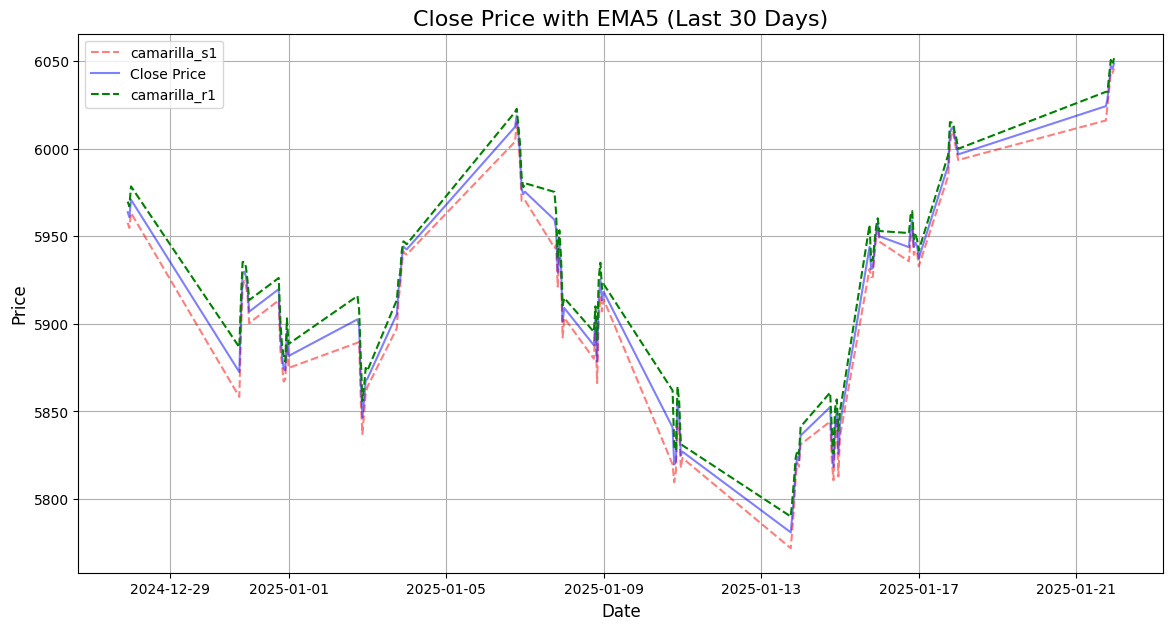

In [8]:
import matplotlib.pyplot as plt

# Select a subset of the data (e.g., last 30 days)
df_subset = df[-100:]  # آخرین 30 روز داده

# Plot the closing prices and EMA5
plt.figure(figsize=(14, 7))
plt.plot(df_subset.index, df_subset['camarilla_s1'], label='camarilla_s1', color='red', alpha=0.5,linestyle='--')
plt.plot(df_subset.index, df_subset['close'], label='Close Price', color='blue', alpha=0.5)
plt.plot(df_subset.index, df_subset['camarilla_r1'], label='camarilla_r1', color='green', linestyle='--')

# Add labels and title
plt.title('Close Price with EMA5 (Last 30 Days)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [175]:
features = [#'open',
#  'high',
#  'low',
   'close',
    #  'ema5',
    # 'ema10',
  #  'ema20',
  #  'HA_close',
    # 'HA_open',
  #  'HA_high',
    # 'HA_low',
  # 'ema50',
  # 'ema200',
  #  'atr',
  # 'rsi',
  # 'MACD_12_26_9',
  # 'MACDh_12_26_9',
  # 'MACDs_12_26_9',
      # 'pivot',
    # 'fib_236',
  #  'support_1',
      # 'support_2',
    #  'resistance_1',
        # 'resistance_2']
 # 'BBL_20_2.0',
 # # 'BBM_20_2.0',
 # 'BBU_20_2.0',
 # # 'BBB_20_2.0',
 # # 'BBP_20_2.0',
 # # 'STOCHk_14_3_3',
 # # 'STOCHd_14_3_3',
  # 'ADX_14',
 # # 'DMP_14',
 # # 'DMN_14',
 # 'L14',
 # 'H14',
 # # '%K',
 # # '%D',
  #  'support_3',
  #  'resistance_3']
        #  'fib_382',
    # 'fib_618']
    #  'woodie_pivot']
#  'woodie_s1',
  #  'woodie_r1']
          #  'camarilla_s1',
         'camarilla_r1']
    # 'mid_support',
    # 'mid_resistance']
 # 'alt_pivot',
  # 'pivot_ma7']
 # 'pivot_ma21']
 # # 'daily_range',
 # 'range_pct']
target = ['next_hour_close']

# close              0.999833
# camarilla_s1       0.999827
# camarilla_r1       0.999825
# woodie_pivot       0.999824
# fib_382            0.999819
# pivot              0.999818
# woodie_s1          0.999813
# support_1          0.999810
# woodie_r1          0.999809
# resistance_1       0.999804
# alt_pivot          0.999803
# fib_618            0.999802
# low                0.999782
# mid_support        0.999779
# high               0.999773
# mid_resistance     0.999770
# support_2          0.999737
# resistance_2       0.999722
# open               0.999720
# ema5               0.999698
# support_3          0.999639
# resistance_3       0.999621
# ema10              0.999494
# pivot_ma7          0.999487
# ema20              0.999074
# L14                0.998902
# BBM_20_2.0         0.998797
# H14                0.998785
# pivot_ma21         0.998697
# BBL_20_2.0         0.998270
# BBU_20_2.0         0.998088
# ema50              0.997838
# ema200             0.992243

In [176]:
X = df[features].values
y = df[target].values.reshape(-1, 1)

In [177]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()


X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

In [178]:
Sequence_len = 40

def creat_sequences(X,y,sequence_len):
  X_seq = []
  y_seq = []
  for i in range(len(X)-sequence_len):
    X_seq.append(X[i:i+sequence_len])
    y_seq.append(y[i+sequence_len])
  return np.array(X_seq),np.array(y_seq)

In [179]:
X_final,y_final = creat_sequences(X_scaled,y_scaled,Sequence_len)

In [180]:
print(X_final.shape)
print(y_final.shape)

(10378, 40, 2)
(10378, 1)


In [181]:
split_index = int(len(X_final)*0.90)
x_train = X_final[:split_index]
y_train = y_final[:split_index]
x_test = X_final[split_index:]
y_test = y_final[split_index:]

In [182]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(9340, 40, 2)
(9340, 1)
(1038, 40, 2)
(1038, 1)


In [183]:

model = Sequential()
model.add(Input(shape=(Sequence_len, x_train.shape[2])))
model.add(LSTM(384,kernel_regularizer=l2(5.549602976953121e-05)))
model.add(Dense(48,kernel_regularizer=l2(1.0993810979042252e-06)))
model.add(Dense(1, activation='linear'))


model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 384)                 │         594,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 48)                  │          18,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              49 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 612,961 (2.34 MB)

 Trainable params: 612,961 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

In [184]:
Es = EarlyStopping(monitor='val_mae',patience=10)
learning_rate = 0.001
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
# history = model.fit(x_train, y_train, epochs=200, validation_data=(x_train, y_train),callbacks=Es)
history = model.fit(x_train, y_train, epochs=200, validation_data=(x_train, y_train),callbacks=Es)

Epoch 1/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0268 - mae: 0.0711 - val_loss: 0.0014 - val_mae: 0.0231
Epoch 2/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0013 - mae: 0.0234 - val_loss: 0.0013 - val_mae: 0.0231
Epoch 3/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0013 - mae: 0.0231 - val_loss: 0.0012 - val_mae: 0.0216
Epoch 4/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0012 - mae: 0.0228 - val_loss: 0.0011 - val_mae: 0.0198
Epoch 5/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0011 - mae: 0.0214 - val_loss: 0.0012 - val_mae: 0.0220
Epoch 6/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0011 - mae: 0.0220 - val_loss: 0.0010 - val_mae: 0.0197
Epoch 7/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0010 - mae: 0.0209 - val_loss: 9.6389e-04 - val_mae: 0.0193
Epoch 8/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0010 - mae: 0.0208 - val_loss: 9.4702e-04 - val_mae: 0.0189
Epoch 9/200
292/292 ━━━━━━━━━━━

In [185]:
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3549e-04 - mae: 0.0195
Test Loss: 0.0010328423231840134, Test MAE: 0.02050572820007801


In [186]:
y_pred = model.predict(x_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [187]:
y_pred = y_scaler.inverse_transform(y_pred)
y_test = y_scaler.inverse_transform(y_test)


In [188]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_pred)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")
# MAE: 13.343064404483949
# MSE: 362.7158214445263
# RMSE: 19.045099670112684
# R-squared: 0.9703762322465218

MAE: 17.671248231274088
MSE: 712.1603578667787
RMSE: 26.686332791651584
R-squared: 0.9853318751498796


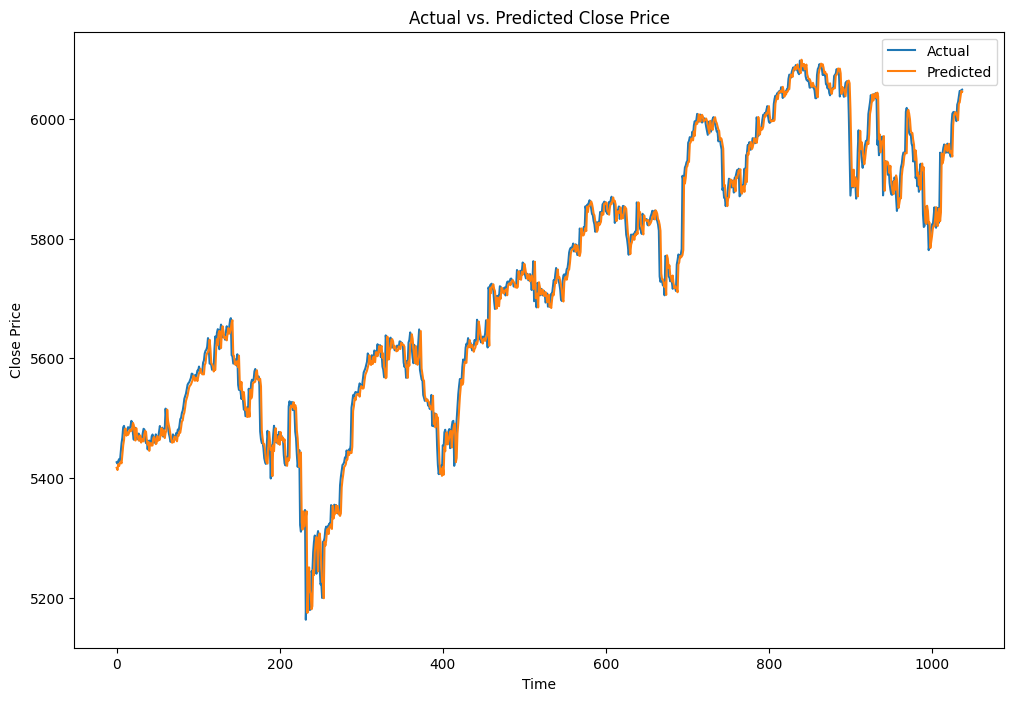

In [189]:
plt.figure(figsize=(12, 8))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [190]:
df_results = pd.DataFrame({
    'Actual': y_test.flatten(),
    'Predicted': y_pred.flatten()
}, index=df.index[-len(y_test):])

df_results.to_csv('prediction_results_SPX04.csv')

# print("Results saved to 'prediction_results_SPX04.csv'")
# from google.colab import files

# files.download('prediction_results_SPX04.csv')

In [191]:
def evaluate_predictions(y_test, y_pred):
    # محاسبه معیارهای دقت مدل
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

    # بررسی جهت حرکت قیمت‌ها
    correct_direction = np.sum(np.sign(y_pred[1:] - y_pred[:-1]) == np.sign(y_test[1:] - y_test[:-1]))
    accuracy = correct_direction / (len(y_test) - 1) * 100

    print(f"Trend Direction Accuracy: {accuracy:.2f}%")

In [192]:
evaluate_predictions(y_test, y_pred)


Mean Absolute Error (MAE): 17.6712
Root Mean Squared Error (RMSE): 26.6863
Mean Absolute Percentage Error (MAPE): 0.31%
Trend Direction Accuracy: 48.79%
